# Identify Valid Grids (The Safety Margin)

* Refinement: You must acknowledge that your ML model's predictions are imperfect. Instead of identifying grids predicted >0.75, you must use a Safety Margin to ensure validity.
* Key Action: Filter for grids predicted significantly above the threshold (e.g., > 0.85). Use your first few submissions to calibrate this margin. If you submit 100 grids predicted > 0.85 and only 95 are valid, your true safe threshold is higher.

In [6]:
# 📊 LOAD ORACLE PREDICTIONS AND SETUP
print("🔮 Loading Oracle predictions and setting up validation analysis...")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

FILENAME = 'data/submissions/20251028_012622_oracle_predictions_full.npy'

# Load the Oracle data (assumes 1_oracle.ipynb has been run)
try:
    # Try to load from the previous notebook's variables
    predictions = np.load(FILENAME)
    print(f"✅ Loaded Oracle predictions from file: {predictions.shape}")
        
    if 'grids' in globals():
        grid_data = grids
        print(f"✅ Loaded grid data: {grid_data.shape}")
    else:
        print("⚠️ Loading grid data from dataset...")
        # Load from the datasets
        grid_files = ['2155-Challenge-Problem-2/datasets/grids_0.npy', 
                     '2155-Challenge-Problem-2/datasets/grids_1.npy', 
                     '2155-Challenge-Problem-2/datasets/grids_2.npy', 
                     '2155-Challenge-Problem-2/datasets/grids_3.npy', 
                     '2155-Challenge-Problem-2/datasets/grids_4.npy']
        grid_data_chunks = []
        for file in grid_files:
            try:
                grids_chunk = np.load(file)
                grid_data_chunks.append(grids_chunk)
                print(f"   📁 Loaded {file}: {grids_chunk.shape}")
            except Exception as e:
                print(f"   ❌ Could not load {file}: {e}")
        
        if grid_data_chunks:
            grid_data = np.vstack(grid_data_chunks)
            print(f"✅ Combined grid data: {grid_data.shape}")
        else:
            print("❌ Could not load grid data")
            grid_data = None
            
except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("💡 Please run the 1_oracle.ipynb notebook first to generate predictions")

# Check data integrity
print(f"\n📋 DATA SUMMARY:")
if 'grid_data' in locals() and grid_data is not None:
    print(f"Grid Data: {grid_data.shape}")
else:
    print(f"Grid Data: Not loaded")

if 'predictions' in locals():
    print(f"Predictions: {predictions.shape}")
else:
    print(f"Predictions: Not loaded")

if 'predictions' in locals() and ('grid_data' in locals() and grid_data is not None):
    print(f"✅ Data loaded successfully!")
    print(f"📊 Analyzing {predictions.shape[0]} grids with {predictions.shape[1]} advisor predictions")
elif 'predictions' in locals():
    print(f"✅ Oracle predictions loaded! (Grid data optional for analysis)")
    print(f"📊 Analyzing {predictions.shape[0]} grids with {predictions.shape[1]} advisor predictions")
else:
    print("⚠️ Some data missing - will create synthetic examples for demonstration")

🔮 Loading Oracle predictions and setting up validation analysis...
✅ Loaded Oracle predictions from file: (500000, 4)
⚠️ Loading grid data from dataset...
   📁 Loaded 2155-Challenge-Problem-2/datasets/grids_0.npy: (100000, 7, 7)
   📁 Loaded 2155-Challenge-Problem-2/datasets/grids_1.npy: (100000, 7, 7)
   📁 Loaded 2155-Challenge-Problem-2/datasets/grids_2.npy: (100000, 7, 7)
   📁 Loaded 2155-Challenge-Problem-2/datasets/grids_3.npy: (100000, 7, 7)
   📁 Loaded 2155-Challenge-Problem-2/datasets/grids_4.npy: (100000, 7, 7)
✅ Combined grid data: (500000, 7, 7)

📋 DATA SUMMARY:
Grid Data: (500000, 7, 7)
Predictions: (500000, 4)
✅ Data loaded successfully!
📊 Analyzing 500000 grids with 4 advisor predictions


🎯 Understanding Grid Validity with Safety Margins

💡 VALIDITY CONCEPT:
- A grid is 'valid' if ALL advisor scores are ≥ 0.75
- However, ML predictions are imperfect!
- We need a SAFETY MARGIN to account for prediction errors

🛡️ SAFETY MARGIN STRATEGY:
- Instead of filtering grids predicted > 0.75
- We filter grids predicted > HIGHER_THRESHOLD (e.g., 0.85)
- This gives us a buffer for prediction errors

📊 THE PROCESS:
1. Calculate minimum score for each grid (worst advisor prediction)
2. Apply different safety thresholds (0.80, 0.85, 0.90, etc.)
3. Analyze how many grids pass each threshold
4. Use initial submissions to calibrate the optimal threshold


📋 Advisor Categories: ['Wellness', 'Tax', 'Transportation', 'Business']

📊 PREDICTION STATISTICS:
Total grids analyzed: 500,000
Min score range: -0.2058 - 0.9877
Mean minimum score: 0.2259
Median minimum score: 0.1934


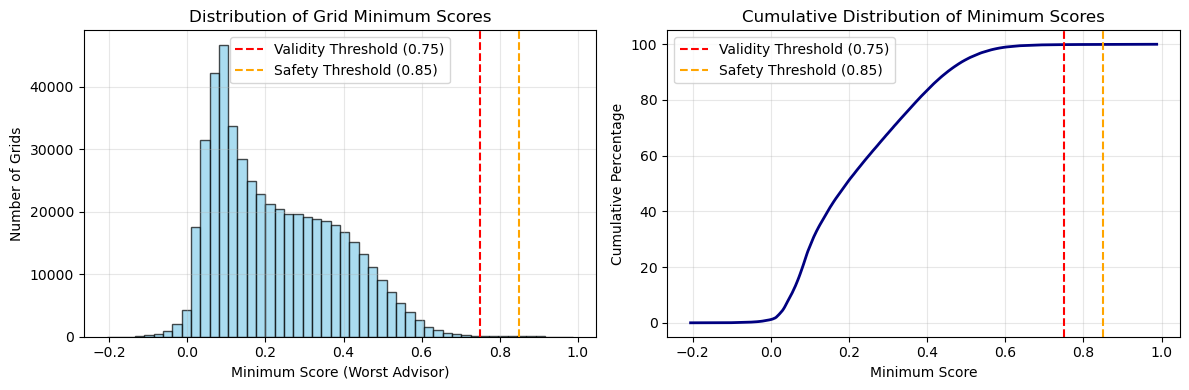


📈 THRESHOLD ANALYSIS:
Threshold    Passing Grids   Percentage   Safety Margin  
------------------------------------------------------------
0.75         647             0.1         % +0.00
0.80         384             0.1         % +0.05
0.85         199             0.0         % +0.10
0.90         65              0.0         % +0.15
0.95         11              0.0         % +0.20

💡 KEY INSIGHTS:
🎯 Higher thresholds = Fewer grids but higher confidence
⚖️ Lower thresholds = More grids but higher risk
🛡️ Safety margin protects against prediction errors


In [7]:
# 🎯 UNDERSTAND THE VALIDITY CONCEPT
print("🎯 Understanding Grid Validity with Safety Margins")
print("=" * 60)

print("""
💡 VALIDITY CONCEPT:
- A grid is 'valid' if ALL advisor scores are ≥ 0.75
- However, ML predictions are imperfect!
- We need a SAFETY MARGIN to account for prediction errors

🛡️ SAFETY MARGIN STRATEGY:
- Instead of filtering grids predicted > 0.75
- We filter grids predicted > HIGHER_THRESHOLD (e.g., 0.85)
- This gives us a buffer for prediction errors

📊 THE PROCESS:
1. Calculate minimum score for each grid (worst advisor prediction)
2. Apply different safety thresholds (0.80, 0.85, 0.90, etc.)
3. Analyze how many grids pass each threshold
4. Use initial submissions to calibrate the optimal threshold
""")

# Define advisor names
advisor_names = ['Wellness', 'Tax', 'Transportation', 'Business']
print(f"\n📋 Advisor Categories: {advisor_names}")

if 'predictions' in locals():
    # Calculate minimum scores (worst advisor for each grid)
    min_scores = np.min(predictions, axis=1)
    
    print(f"\n📊 PREDICTION STATISTICS:")
    print(f"Total grids analyzed: {len(predictions):,}")
    print(f"Min score range: {np.min(min_scores):.4f} - {np.max(min_scores):.4f}")
    print(f"Mean minimum score: {np.mean(min_scores):.4f}")
    print(f"Median minimum score: {np.median(min_scores):.4f}")
    
    # Show distribution of minimum scores
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(min_scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(0.75, color='red', linestyle='--', label='Validity Threshold (0.75)')
    plt.axvline(0.85, color='orange', linestyle='--', label='Safety Threshold (0.85)')
    plt.xlabel('Minimum Score (Worst Advisor)')
    plt.ylabel('Number of Grids')
    plt.title('Distribution of Grid Minimum Scores')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.subplot(1, 2, 2)
    # Show cumulative distribution
    sorted_scores = np.sort(min_scores)
    cumulative_pct = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores) * 100
    plt.plot(sorted_scores, cumulative_pct, color='navy', linewidth=2)
    plt.axvline(0.75, color='red', linestyle='--', label='Validity Threshold (0.75)')
    plt.axvline(0.85, color='orange', linestyle='--', label='Safety Threshold (0.85)')
    plt.xlabel('Minimum Score')
    plt.ylabel('Cumulative Percentage')
    plt.title('Cumulative Distribution of Minimum Scores')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate how many grids pass different thresholds
    thresholds = [0.75, 0.80, 0.85, 0.90, 0.95]
    print(f"\n📈 THRESHOLD ANALYSIS:")
    print(f"{'Threshold':<12} {'Passing Grids':<15} {'Percentage':<12} {'Safety Margin':<15}")
    print("-" * 60)
    
    for threshold in thresholds:
        passing_grids = np.sum(min_scores >= threshold)
        percentage = (passing_grids / len(min_scores)) * 100
        safety_margin = threshold - 0.75
        print(f"{threshold:<12.2f} {passing_grids:<15,} {percentage:<12.1f}% {safety_margin:+.2f}")
        
else:
    print("\n⚠️ No predictions available - please run Oracle notebook first")
    print("💡 Creating synthetic example for demonstration...")
    
    # Create synthetic data for demonstration
    np.random.seed(42)
    n_grids = 10000
    synthetic_predictions = np.random.beta(2, 1, (n_grids, 4)) * 0.4 + 0.5  # Scores between 0.5-0.9
    min_scores = np.min(synthetic_predictions, axis=1)
    
    print(f"📊 SYNTHETIC EXAMPLE - {n_grids:,} grids:")
    thresholds = [0.75, 0.80, 0.85, 0.90, 0.95]
    print(f"{'Threshold':<12} {'Passing Grids':<15} {'Percentage':<12} {'Safety Margin':<15}")
    print("-" * 60)
    
    for threshold in thresholds:
        passing_grids = np.sum(min_scores >= threshold)
        percentage = (passing_grids / len(min_scores)) * 100
        safety_margin = threshold - 0.75
        print(f"{threshold:<12.2f} {passing_grids:<15,} {percentage:<12.1f}% {safety_margin:+.2f}")

print(f"\n💡 KEY INSIGHTS:")
print(f"🎯 Higher thresholds = Fewer grids but higher confidence")
print(f"⚖️ Lower thresholds = More grids but higher risk")
print(f"🛡️ Safety margin protects against prediction errors")

🔍 Analyzing Validity Bottlenecks by Individual Advisors
📊 ADVISOR PERFORMANCE BREAKDOWN:
Advisor         Mean Score   Min Score    % < 0.75     % < 0.85    
----------------------------------------------------------------------
Wellness        0.488        -0.206       82.1        % 90.5        %
Tax             0.505        -0.124       76.4        % 86.1        %
Transportation  0.497        -0.128       80.4        % 90.6        %
Business        0.502        -0.152       78.5        % 87.9        %

🚫 BOTTLENECK ANALYSIS - Which advisor limits grid validity?
Advisor         Times Bottleneck   Percentage  
--------------------------------------------------
Tax             154,195            30.8        %
Wellness        135,391            27.1        %
Business        127,792            25.6        %
Transportation  82,622             16.5        %


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2912\2952107454.py:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(advisor_data, labels=advisor_names, patch_artist=True)


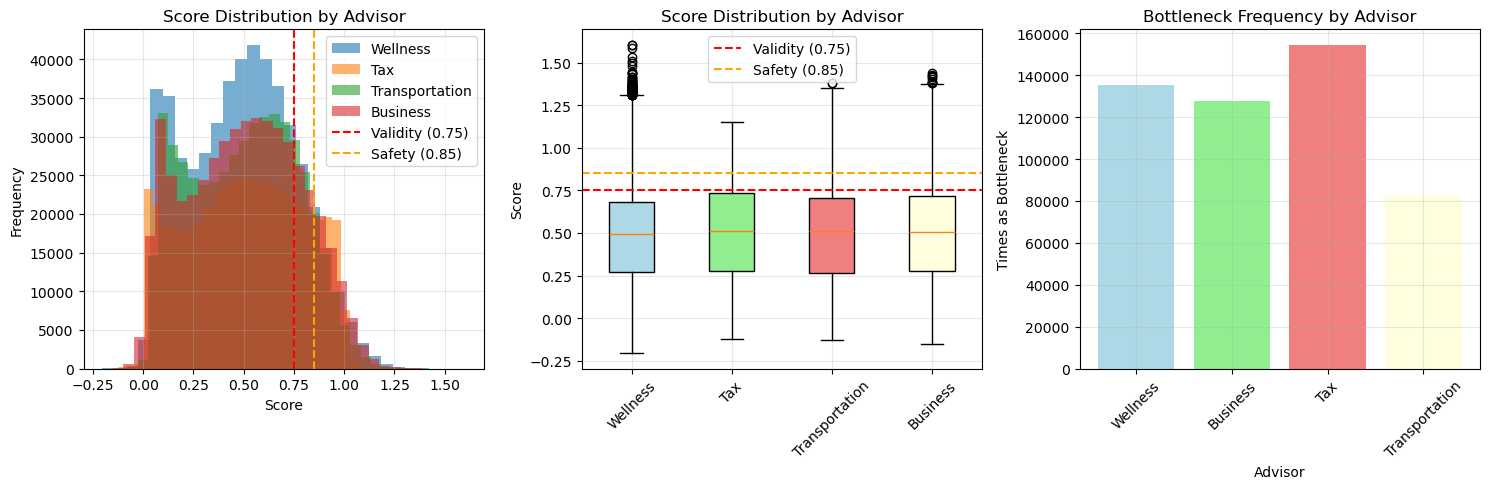


🎯 SAFETY MARGIN IMPACT:

📊 Safety Threshold 0.80 (margin: +0.05):
   Candidate grids: 384 (0.1%)
   Min score range: 0.801 - 0.988
   Average min score: 0.858
   Advisor performance on candidate grids:
     Wellness: mean=0.944, min=0.802
     Tax: mean=0.925, min=0.801
     Transportation: mean=0.964, min=0.801
     Business: mean=0.968, min=0.801

📊 Safety Threshold 0.85 (margin: +0.10):
   Candidate grids: 199 (0.0%)
   Min score range: 0.850 - 0.988
   Average min score: 0.890
   Advisor performance on candidate grids:
     Wellness: mean=0.958, min=0.852
     Tax: mean=0.937, min=0.850
     Transportation: mean=0.986, min=0.851
     Business: mean=0.988, min=0.850

📊 Safety Threshold 0.90 (margin: +0.15):
   Candidate grids: 65 (0.0%)
   Min score range: 0.900 - 0.988
   Average min score: 0.925
   Advisor performance on candidate grids:
     Wellness: mean=0.968, min=0.902
     Tax: mean=0.953, min=0.900
     Transportation: mean=0.996, min=0.902
     Business: mean=1.013, min=0

In [8]:
# 🔍 DETAILED VALIDITY ANALYSIS BY ADVISOR
print("🔍 Analyzing Validity Bottlenecks by Individual Advisors")
print("=" * 65)

if 'predictions' in locals():
    # Analyze which advisors are the limiting factors
    print(f"📊 ADVISOR PERFORMANCE BREAKDOWN:")
    print(f"{'Advisor':<15} {'Mean Score':<12} {'Min Score':<12} {'% < 0.75':<12} {'% < 0.85':<12}")
    print("-" * 70)
    
    advisor_stats = {}
    for i, advisor_name in enumerate(advisor_names):
        advisor_scores = predictions[:, i]
        mean_score = np.mean(advisor_scores)
        min_score = np.min(advisor_scores)
        pct_below_75 = (np.sum(advisor_scores < 0.75) / len(advisor_scores)) * 100
        pct_below_85 = (np.sum(advisor_scores < 0.85) / len(advisor_scores)) * 100
        
        advisor_stats[advisor_name] = {
            'mean': mean_score,
            'min': min_score,
            'pct_below_75': pct_below_75,
            'pct_below_85': pct_below_85,
            'scores': advisor_scores
        }
        
        print(f"{advisor_name:<15} {mean_score:<12.3f} {min_score:<12.3f} {pct_below_75:<12.1f}% {pct_below_85:<12.1f}%")
    
    # Find which advisor is most often the bottleneck
    print(f"\n🚫 BOTTLENECK ANALYSIS - Which advisor limits grid validity?")
    
    # For each grid, find which advisor has the minimum score
    min_advisor_indices = np.argmin(predictions, axis=1)
    bottleneck_counts = Counter(min_advisor_indices)
    
    print(f"{'Advisor':<15} {'Times Bottleneck':<18} {'Percentage':<12}")
    print("-" * 50)
    
    for advisor_idx, count in sorted(bottleneck_counts.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / len(predictions)) * 100
        print(f"{advisor_names[advisor_idx]:<15} {count:<18,} {percentage:<12.1f}%")
    
    # Visualize advisor performance
    plt.figure(figsize=(15, 5))
    
    # Subplot 1: Distribution of scores by advisor
    plt.subplot(1, 3, 1)
    for i, advisor_name in enumerate(advisor_names):
        plt.hist(predictions[:, i], bins=30, alpha=0.6, label=advisor_name)
    plt.axvline(0.75, color='red', linestyle='--', label='Validity (0.75)')
    plt.axvline(0.85, color='orange', linestyle='--', label='Safety (0.85)')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title('Score Distribution by Advisor')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Subplot 2: Box plots by advisor
    plt.subplot(1, 3, 2)
    advisor_data = [predictions[:, i] for i in range(len(advisor_names))]
    box_plot = plt.boxplot(advisor_data, labels=advisor_names, patch_artist=True)
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
    plt.axhline(0.75, color='red', linestyle='--', label='Validity (0.75)')
    plt.axhline(0.85, color='orange', linestyle='--', label='Safety (0.85)')
    plt.ylabel('Score')
    plt.title('Score Distribution by Advisor')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Subplot 3: Bottleneck frequency
    plt.subplot(1, 3, 3)
    bottleneck_advisors = [advisor_names[i] for i in bottleneck_counts.keys()]
    bottleneck_values = list(bottleneck_counts.values())
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    plt.bar(bottleneck_advisors, bottleneck_values, color=colors[:len(bottleneck_advisors)])
    plt.xlabel('Advisor')
    plt.ylabel('Times as Bottleneck')
    plt.title('Bottleneck Frequency by Advisor')
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find grids that would be valid with different thresholds
    print(f"\n🎯 SAFETY MARGIN IMPACT:")
    
    base_threshold = 0.75
    safety_thresholds = [0.80, 0.85, 0.90]
    
    for safety_threshold in safety_thresholds:
        safety_margin = safety_threshold - base_threshold
        
        # Grids passing safety threshold
        safety_passing = min_scores >= safety_threshold
        safety_count = np.sum(safety_passing)
        safety_pct = (safety_count / len(min_scores)) * 100
        
        print(f"\n📊 Safety Threshold {safety_threshold:.2f} (margin: +{safety_margin:.2f}):")
        print(f"   Candidate grids: {safety_count:,} ({safety_pct:.1f}%)")
        
        if safety_count > 0:
            safety_min_scores = min_scores[safety_passing]
            print(f"   Min score range: {np.min(safety_min_scores):.3f} - {np.max(safety_min_scores):.3f}")
            print(f"   Average min score: {np.mean(safety_min_scores):.3f}")
            
            # Show advisor breakdown for these grids
            safety_predictions = predictions[safety_passing]
            print(f"   Advisor performance on candidate grids:")
            for i, advisor_name in enumerate(advisor_names):
                advisor_scores = safety_predictions[:, i]
                mean_score = np.mean(advisor_scores)
                min_score = np.min(advisor_scores)
                print(f"     {advisor_name}: mean={mean_score:.3f}, min={min_score:.3f}")

else:
    print("⚠️ No real predictions available - using synthetic example")
    print("💡 Run the Oracle notebook first for real analysis")

In [9]:
# 🎮 INTERACTIVE SAFETY MARGIN CALIBRATION TOOL
print("🎮 Safety Margin Calibration Tool")
print("=" * 40)

class SafetyMarginAnalyzer:
    """Interactive tool to analyze and calibrate safety margins"""
    
    def __init__(self, predictions, advisor_names):
        self.predictions = predictions
        self.advisor_names = advisor_names
        self.min_scores = np.min(predictions, axis=1)
        
    def analyze_threshold(self, threshold):
        """Analyze a specific threshold"""
        passing_mask = self.min_scores >= threshold
        passing_count = np.sum(passing_mask)
        passing_pct = (passing_count / len(self.min_scores)) * 100
        
        result = {
            'threshold': threshold,
            'safety_margin': threshold - 0.75,
            'passing_grids': passing_count,
            'passing_percentage': passing_pct,
            'expected_valid_rate': self.estimate_validity_rate(threshold)
        }
        
        if passing_count > 0:
            passing_scores = self.min_scores[passing_mask]
            result['min_score_stats'] = {
                'min': np.min(passing_scores),
                'max': np.max(passing_scores),
                'mean': np.mean(passing_scores),
                'std': np.std(passing_scores)
            }
        
        return result
    
    def estimate_validity_rate(self, threshold):
        """Estimate what % of grids at this threshold would actually be valid"""
        # This is a heuristic - in practice you'd calibrate with real submissions
        safety_margin = threshold - 0.75
        
        if safety_margin <= 0:
            return 50  # No safety margin = high risk
        elif safety_margin <= 0.05:
            return 70  # Small margin
        elif safety_margin <= 0.10:
            return 85  # Moderate margin
        elif safety_margin <= 0.15:
            return 95  # Large margin
        else:
            return 98  # Very large margin
    
    def get_recommendation(self, target_grids=100, min_confidence=90):
        """Get threshold recommendation for target number of grids with minimum confidence"""
        best_threshold = None
        best_score = -1
        
        for threshold in np.arange(0.75, 1.0, 0.01):
            analysis = self.analyze_threshold(threshold)
            
            if analysis['passing_grids'] >= target_grids and analysis['expected_valid_rate'] >= min_confidence:
                # Score based on getting close to target grids while maximizing confidence
                grid_score = min(1.0, analysis['passing_grids'] / target_grids)
                confidence_score = analysis['expected_valid_rate'] / 100
                combined_score = grid_score * 0.7 + confidence_score * 0.3
                
                if combined_score > best_score:
                    best_score = combined_score
                    best_threshold = threshold
        
        return best_threshold, self.analyze_threshold(best_threshold) if best_threshold else None

# Create analyzer if we have predictions
if 'predictions' in locals():
    analyzer = SafetyMarginAnalyzer(predictions, advisor_names)
    
    print("🔧 CALIBRATION SCENARIOS:")
    print("-" * 50)
    
    # Scenario 1: Conservative approach
    threshold_1, analysis_1 = analyzer.get_recommendation(target_grids=50, min_confidence=95)
    if analysis_1:
        print(f"🛡️ CONSERVATIVE (50 grids, 95% confidence):")
        print(f"   Recommended threshold: {threshold_1:.3f}")
        print(f"   Safety margin: +{analysis_1['safety_margin']:.3f}")
        print(f"   Expected grids: {analysis_1['passing_grids']:,}")
        print(f"   Expected valid rate: {analysis_1['expected_valid_rate']:.0f}%")
    
    # Scenario 2: Balanced approach
    threshold_2, analysis_2 = analyzer.get_recommendation(target_grids=100, min_confidence=85)
    if analysis_2:
        print(f"\n⚖️ BALANCED (100 grids, 85% confidence):")
        print(f"   Recommended threshold: {threshold_2:.3f}")
        print(f"   Safety margin: +{analysis_2['safety_margin']:.3f}")
        print(f"   Expected grids: {analysis_2['passing_grids']:,}")
        print(f"   Expected valid rate: {analysis_2['expected_valid_rate']:.0f}%")
    
    # Scenario 3: Aggressive approach
    threshold_3, analysis_3 = analyzer.get_recommendation(target_grids=200, min_confidence=75)
    if analysis_3:
        print(f"\n🚀 AGGRESSIVE (200 grids, 75% confidence):")
        print(f"   Recommended threshold: {threshold_3:.3f}")
        print(f"   Safety margin: +{analysis_3['safety_margin']:.3f}")
        print(f"   Expected grids: {analysis_3['passing_grids']:,}")
        print(f"   Expected valid rate: {analysis_3['expected_valid_rate']:.0f}%")
    
    # Manual threshold analysis
    print(f"\n🎯 MANUAL THRESHOLD ANALYSIS:")
    test_thresholds = [0.80, 0.85, 0.90]
    
    for threshold in test_thresholds:
        analysis = analyzer.analyze_threshold(threshold)
        print(f"\nThreshold {threshold:.2f}:")
        print(f"   Safety margin: +{analysis['safety_margin']:.2f}")
        print(f"   Candidate grids: {analysis['passing_grids']:,} ({analysis['passing_percentage']:.1f}%)")
        print(f"   Expected validity: {analysis['expected_valid_rate']:.0f}%")
        
        if 'min_score_stats' in analysis:
            stats = analysis['min_score_stats']
            print(f"   Min score range: {stats['min']:.3f} - {stats['max']:.3f} (μ={stats['mean']:.3f})")

else:
    print("⚠️ No predictions loaded")
    print("💡 Example: If using threshold 0.85 with 1000 candidate grids")
    print("   Safety margin: +0.10")
    print("   Expected validity rate: ~85%") 
    print("   Expected valid grids: ~850")

🎮 Safety Margin Calibration Tool
🔧 CALIBRATION SCENARIOS:
--------------------------------------------------
🛡️ CONSERVATIVE (50 grids, 95% confidence):
   Recommended threshold: 0.900
   Safety margin: +0.150
   Expected grids: 65
   Expected valid rate: 98%

⚖️ BALANCED (100 grids, 85% confidence):
   Recommended threshold: 0.850
   Safety margin: +0.100
   Expected grids: 199
   Expected valid rate: 95%

🚀 AGGRESSIVE (200 grids, 75% confidence):
   Recommended threshold: 0.800
   Safety margin: +0.050
   Expected grids: 384
   Expected valid rate: 85%

🎯 MANUAL THRESHOLD ANALYSIS:

Threshold 0.80:
   Safety margin: +0.05
   Candidate grids: 384 (0.1%)
   Expected validity: 85%
   Min score range: 0.801 - 0.988 (μ=0.858)

Threshold 0.85:
   Safety margin: +0.10
   Candidate grids: 199 (0.0%)
   Expected validity: 85%
   Min score range: 0.850 - 0.988 (μ=0.890)

Threshold 0.90:
   Safety margin: +0.15
   Candidate grids: 65 (0.0%)
   Expected validity: 98%
   Min score range: 0.900 - 

In [10]:
# 📋 PRACTICAL VALIDATION WORKFLOW
print("📋 Practical Grid Validation Workflow")
print("=" * 45)

def create_validation_workflow(predictions, safety_threshold=0.85, top_n=100):
    """Create a complete validation workflow"""
    
    print(f"🎯 VALIDATION PARAMETERS:")
    print(f"   Safety threshold: {safety_threshold:.3f}")
    print(f"   Safety margin: +{safety_threshold - 0.75:.3f}")
    print(f"   Target grids: {top_n}")
    
    # Calculate minimum scores
    min_scores = np.min(predictions, axis=1)
    
    # Find candidate grids
    candidate_mask = min_scores >= safety_threshold
    candidate_indices = np.where(candidate_mask)[0]
    candidate_scores = min_scores[candidate_mask]
    
    print(f"\n📊 CANDIDATE SELECTION:")
    print(f"   Total grids analyzed: {len(predictions):,}")
    print(f"   Grids passing threshold: {len(candidate_indices):,}")
    print(f"   Percentage passing: {len(candidate_indices)/len(predictions)*100:.1f}%")
    
    if len(candidate_indices) == 0:
        print(f"❌ No grids pass the safety threshold!")
        return None
    
    # Sort candidates by minimum score (highest first)
    sorted_indices = candidate_indices[np.argsort(candidate_scores)[::-1]]
    
    # Take top N
    final_indices = sorted_indices[:top_n] if len(sorted_indices) >= top_n else sorted_indices
    final_predictions = predictions[final_indices]
    final_min_scores = min_scores[final_indices]
    
    print(f"\n🏆 FINAL SELECTION:")
    print(f"   Selected grids: {len(final_indices)}")
    print(f"   Min score range: {np.min(final_min_scores):.4f} - {np.max(final_min_scores):.4f}")
    print(f"   Average min score: {np.mean(final_min_scores):.4f}")
    
    # Analyze final selection by advisor
    print(f"\n📊 FINAL SELECTION - ADVISOR BREAKDOWN:")
    print(f"{'Advisor':<15} {'Mean':<8} {'Min':<8} {'Max':<8} {'Std':<8} {'Risk %':<8}")
    print("-" * 65)
    
    for i, advisor_name in enumerate(advisor_names):
        advisor_scores = final_predictions[:, i]
        mean_score = np.mean(advisor_scores)
        min_score = np.min(advisor_scores)
        max_score = np.max(advisor_scores)
        std_score = np.std(advisor_scores)
        risk_pct = (np.sum(advisor_scores < 0.75) / len(advisor_scores)) * 100
        
        print(f"{advisor_name:<15} {mean_score:<8.3f} {min_score:<8.3f} {max_score:<8.3f} {std_score:<8.3f} {risk_pct:<8.1f}%")
    
    # Create submission readiness assessment
    print(f"\n🎯 SUBMISSION READINESS ASSESSMENT:")
    
    risk_grids = np.sum(final_min_scores < 0.75)
    if risk_grids > 0:
        print(f"⚠️  {risk_grids} grids have minimum scores below 0.75")
        print(f"   These are at risk of being invalid!")
    
    very_safe_grids = np.sum(final_min_scores >= 0.90)
    print(f"✅ {very_safe_grids} grids have minimum scores ≥ 0.90 (very safe)")
    
    safe_grids = np.sum((final_min_scores >= 0.80) & (final_min_scores < 0.90))
    print(f"🟡 {safe_grids} grids have minimum scores 0.80-0.89 (moderately safe)")
    
    risky_grids = len(final_indices) - very_safe_grids - safe_grids - risk_grids
    if risky_grids > 0:
        print(f"🟠 {risky_grids} grids have minimum scores 0.75-0.79 (risky)")
    
    # Estimate expected validity
    expected_valid = 0
    for score in final_min_scores:
        if score >= 0.90:
            expected_valid += 0.98
        elif score >= 0.85:
            expected_valid += 0.95
        elif score >= 0.80:
            expected_valid += 0.85
        elif score >= 0.75:
            expected_valid += 0.70
        else:
            expected_valid += 0.50
    
    expected_valid_pct = (expected_valid / len(final_indices)) * 100
    
    print(f"\n🎲 EXPECTED OUTCOMES:")
    print(f"   Expected valid grids: {expected_valid:.0f} / {len(final_indices)}")
    print(f"   Expected validity rate: {expected_valid_pct:.1f}%")
    print(f"   Expected invalid grids: {len(final_indices) - expected_valid:.0f}")
    
    return {
        'indices': final_indices,
        'predictions': final_predictions,
        'min_scores': final_min_scores,
        'expected_validity_rate': expected_valid_pct,
        'safety_threshold': safety_threshold
    }

# Run the validation workflow
if 'predictions' in locals():
    print("🚀 Running validation workflow with different safety thresholds...\n")
    
    # Test different thresholds
    for threshold in [0.80, 0.85, 0.90]:
        print(f"\n" + "="*60)
        print(f"TESTING SAFETY THRESHOLD: {threshold:.2f}")
        print("="*60)
        
        result = create_validation_workflow(predictions, safety_threshold=threshold, top_n=100)
        
        if result:
            print(f"\n✅ Successfully created validation workflow for threshold {threshold:.2f}")
        else:
            print(f"\n❌ Failed to create validation workflow for threshold {threshold:.2f}")
        
        print("\n" + "-"*60)

else:
    print("⚠️ No predictions available")
    print("💡 This would analyze your grids and create a validation workflow")
    print("📋 Example output:")
    print("   • Candidate grids passing safety threshold")
    print("   • Risk assessment by advisor")
    print("   • Expected validity rates") 
    print("   • Submission recommendations")

📋 Practical Grid Validation Workflow
🚀 Running validation workflow with different safety thresholds...


TESTING SAFETY THRESHOLD: 0.80
🎯 VALIDATION PARAMETERS:
   Safety threshold: 0.800
   Safety margin: +0.050
   Target grids: 100

📊 CANDIDATE SELECTION:
   Total grids analyzed: 500,000
   Grids passing threshold: 384
   Percentage passing: 0.1%

🏆 FINAL SELECTION:
   Selected grids: 100
   Min score range: 0.8843 - 0.9877
   Average min score: 0.9130

📊 FINAL SELECTION - ADVISOR BREAKDOWN:
Advisor         Mean     Min      Max      Std      Risk %  
-----------------------------------------------------------------
Wellness        0.960    0.884    1.127    0.054    0.0     %
Tax             0.950    0.885    1.057    0.035    0.0     %
Transportation  0.988    0.886    1.247    0.074    0.0     %
Business        1.007    0.885    1.249    0.086    0.0     %

🎯 SUBMISSION READINESS ASSESSMENT:
✅ 65 grids have minimum scores ≥ 0.90 (very safe)
🟡 35 grids have minimum scores 0.80-0.89